# <center> ML-5. Валидация данных и оценка моделей
---

### 2. Валидация данных. Методы валидации

In [51]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
 
from sklearn import metrics #метрики
from sklearn import model_selection #методы разделения и валидации
from sklearn import linear_model #линейные модели
from sklearn import tree #деревья решений
plt.style.use('seaborn-v0_8') #стиль отрисовки seaborn
%matplotlib inline

In [52]:
water_data = pd.read_csv('data/water_potability.csv')
water_data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [53]:
display(water_data.isnull().mean() * 100)

ph                 14.987790
Hardness            0.000000
Solids              0.000000
Chloramines         0.000000
Sulfate            23.840049
Conductivity        0.000000
Organic_carbon      0.000000
Trihalomethanes     4.945055
Turbidity           0.000000
Potability          0.000000
dtype: float64

In [54]:
#Заполняем пропуски
water_data['ph'] = water_data['ph'].fillna(water_data.groupby('Potability')['ph'].transform('median'))
water_data['Sulfate'] = water_data['Sulfate'].fillna(water_data.groupby('Potability')['Sulfate'].transform('median'))
water_data['Trihalomethanes'] = water_data['Trihalomethanes'].fillna(water_data.groupby('Potability')['Trihalomethanes'].transform('median'))

In [55]:
display(water_data.isnull().mean() * 100)

ph                 0.0
Hardness           0.0
Solids             0.0
Chloramines        0.0
Sulfate            0.0
Conductivity       0.0
Organic_carbon     0.0
Trihalomethanes    0.0
Turbidity          0.0
Potability         0.0
dtype: float64

In [56]:
X = water_data.drop('Potability', axis=1)
y = water_data['Potability']

##### HOLD-OUT

Основные параметры **`train_test_split()`**:

* `*arrays` — порядковый аргумент с переменным количеством. Набор массивов (это могут быть списки, *numpy*-массивы, *DataFrame*), которые подлежат разбиению.
* `test_size` — размер тестовой (валидационной) выборки. Может быть указан в долях. Если параметр `train_size` задан дробным числом с плавающей точкой, то параметр `test_size` определяется автоматически как `1-train_size`.
* `train_size` — размер тренировочной выборки. Может быть указан в долях. Если параметр `test_size` задан дробным числом с плавающей точкой, то параметр `train_size` определяется автоматически как `1-test_size`.
* `random_state` — число, на основе которого производится генерация случайных чисел.
* `shuffle` — параметр, указывающий, стоит ли перемешивать выборку перед разбиением (по умолчанию *True*).
* `stratify` — стратифицированное разбиение (о нём мы поговорим в юните по дисбалансу выборки).

In [57]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

In [58]:
print('Train shape: {}'.format(X_train.shape))
print('Valid shape: {}'.format(X_valid.shape))
  
## Train shape: (2620, 9)
## Valid shape: (656, 9)

Train shape: (2620, 9)
Valid shape: (656, 9)


In [59]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
#Обучаем модель на тренировочной выборке
model.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик
print('Train hold-out accuracy: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Valid hold-out accuracy: {:.2f}'.format(metrics.accuracy_score(y_valid, y_valid_pred))) 
 
# Train hold-out accuracy: 0.82
# Valid hold-out accuracy: 0.77

Train hold-out accuracy: 0.82
Valid hold-out accuracy: 0.77


In [60]:
#разбиваем исходную выборку на тренировочную и валидационную в соотношении 80/20
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
#разбиваем валидационную выборку на валидационную и тестовую в соотношении 50/50
X_valid, X_test, y_valid, y_test = model_selection.train_test_split(X_valid, y_valid, test_size=0.5, random_state=42)

In [61]:
print('Train shape: {}'.format(X_train.shape))
print('Valid shape: {}'.format(X_valid.shape))
print('Test shape: {}'.format(X_test.shape))

## Train shape: (2620, 9)
## Valid shape: (328, 9)
## Test shape: (328, 9)

Train shape: (2620, 9)
Valid shape: (328, 9)
Test shape: (328, 9)


##### K-FOLD

Основные параметры инициализатора **`KFold`**:

* `n_split` — число фолдов (число *k* из метода *k-fold*). По умолчанию — 5.
* `shuffle` — параметр, указывающий, стоит ли перемешивать исходный набор данных перед разбиением. По умолчанию — False.
* `random_state` — число, на основе которого производится генерация случайных чисел, если набор данных будет перемешиваться.

In [62]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
 
#Создаём объект кросс-валидатора KFold
kf = model_selection.KFold(n_splits=5)
#Создаём список для хранения тренировочных и валидационных метрик
train_metrics = []
val_metrics = []
#Организуем цикл для кросс-валидации (используем весь набор данных)
#train_index — индексы тренировочной выборки
#valid_index — индексы валидационной выборки
for train_index, valid_index in kf.split(X, y): 
    #Создаём тренировочную и валидационную выборку, обращаясь по текущим индексам
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]
    #Обучаем дерево решений на тренировочной выборке
    model.fit(X_train, y_train)
    #Делаем предсказание для каждой из выборок
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)
    #Рассчитываем метрику и заносим её в список
    train_metrics.append(metrics.accuracy_score(y_train, y_train_pred))
    val_metrics.append(metrics.accuracy_score(y_valid, y_valid_pred))

In [63]:
print(train_metrics)
print(val_metrics)
 
## [0.8034351145038168, 0.8168637924456315, 0.8027470431133156, 0.8267836703548264, 0.8157191911484166]
## [0.7957317073170732, 0.7053435114503817, 0.7358778625954199, 0.7282442748091603, 0.732824427480916]

[0.8034351145038168, 0.8168637924456315, 0.8027470431133156, 0.8267836703548264, 0.8157191911484166]
[0.7957317073170732, 0.7053435114503817, 0.7358778625954199, 0.7282442748091603, 0.732824427480916]


In [64]:
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(train_metrics)))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(val_metrics)))
 
## Train k-fold mean accuracy: 0.81
## Valid k-fold mean accuracy: 0.74

Train k-fold mean accuracy: 0.81
Valid k-fold mean accuracy: 0.74


Основные параметры функции **`cross_validate()`**:

* `estimator` — модель, качество которой будет проверяться на кросс-валидации.
* `X` — матрица наблюдений.
* `y` — вектор-столбец правильных ответов.
* `cv` — кросс-валидатор из библиотеки *sklearn* (например, *KFold*) или количество фолдов, на которые необходимо разбить выборку. По умолчанию используется кросс-валидация на пяти фолдах.
* `scoring` — название метрики в виде строки либо функция для её вычисления (`'accuracy'`, `'precision'`, `'recall'`, `'f1'` и другие; полный список — в документации к функции).
* `return_train_score` — параметр, указывающий стоит ли возвращать значения метрики, полученные на тренировочных фолдах. По умолчанию — *False*, то есть метрики считаются только на валидационных фолдах.

Функция возвращает словарь со следующими ключами:

* `fit_time` — время обучения модели на каждой итерации кросс-валидации;
* `score_time` — время вычисления метрик на каждой итерации кросс-валидации;
* `test_score` — значения метрик на валидационных фолдах;
* `train_score` — значения метрик на тренировочных фолдах.

In [65]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
 
#Создаём объект кросс-валидатора KFold
kf = model_selection.KFold(n_splits=5)
 
#Считаем метрики на кросс-валидации k-fold
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X, #матрица наблюдений X
    y=y, #вектор ответов y
    cv=kf, #кросс-валидатор
    scoring='accuracy', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
display(cv_metrics)

{'fit_time': array([0.04796743, 0.04700136, 0.04596853, 0.04398584, 0.0469861 ]),
 'score_time': array([0.00201893, 0.00199962, 0.00101995, 0.00198126, 0.00198245]),
 'test_score': array([0.79573171, 0.70534351, 0.73587786, 0.72824427, 0.73282443]),
 'train_score': array([0.80343511, 0.81686379, 0.80274704, 0.82678367, 0.81571919])}

In [66]:
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['test_score'])))
 
## Train k-fold mean accuracy: 0.81
## Valid k-fold mean accuracy: 0.74

Train k-fold mean accuracy: 0.81
Valid k-fold mean accuracy: 0.74


##### LEAVE-ONE-OUT

In [67]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
 
#Создаём кросс-валидатор LeaveOneOut
loo = model_selection.LeaveOneOut()
 
#Считаем метрики на кросс-валидации leave-one-out
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X.iloc[:500], #матрица наблюдений X
    y=y.iloc[:500], #вектор ответов y
    cv=loo, #кросс-валидатор
    scoring='accuracy', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
 
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['test_score'])))
 
## Train k-fold mean accuracy: 0.95
## Valid k-fold mean accuracy: 0.90

Train k-fold mean accuracy: 0.95
Valid k-fold mean accuracy: 0.90


---
### 3. Дисбаланс выборки

Potability
0    0.60989
1    0.39011
Name: proportion, dtype: float64

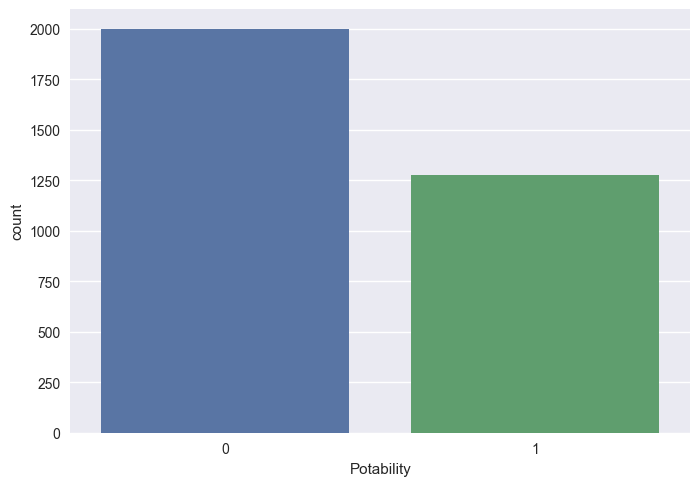

In [68]:
display(water_data['Potability'].value_counts(normalize=True))
sns.countplot(data=water_data, x='Potability', hue='Potability', legend=False);

##### СТРАТИФИЦИРОВАННОЕ РАЗБИЕНИЕ

In [69]:
X, y = water_data.drop('Potability', axis=1), water_data['Potability']
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)
print('Train:\n', y_train.value_counts(normalize=True), sep='')
print('Valid:\n', y_valid.value_counts(normalize=True), sep='')

Train:
Potability
0    0.620229
1    0.379771
Name: proportion, dtype: float64
Valid:
Potability
0    0.568598
1    0.431402
Name: proportion, dtype: float64


In [70]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)
print('Train:\n', y_train.value_counts(normalize=True), sep='')
print('Valid:\n', y_valid.value_counts(normalize=True), sep='')

Train:
Potability
0    0.609924
1    0.390076
Name: proportion, dtype: float64
Valid:
Potability
0    0.609756
1    0.390244
Name: proportion, dtype: float64


In [71]:
skf = model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
for train_index, valid_index in skf.split(X, y): 
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]
    print('Train:\n', y_train.value_counts(normalize=True), sep='')
    print('Valid:\n', y_valid.value_counts(normalize=True), sep='')
    print('-'*40)

Train:
Potability
0    0.60989
1    0.39011
Name: proportion, dtype: float64
Valid:
Potability
0    0.60989
1    0.39011
Name: proportion, dtype: float64
----------------------------------------
Train:
Potability
0    0.60989
1    0.39011
Name: proportion, dtype: float64
Valid:
Potability
0    0.60989
1    0.39011
Name: proportion, dtype: float64
----------------------------------------
Train:
Potability
0    0.60989
1    0.39011
Name: proportion, dtype: float64
Valid:
Potability
0    0.60989
1    0.39011
Name: proportion, dtype: float64
----------------------------------------


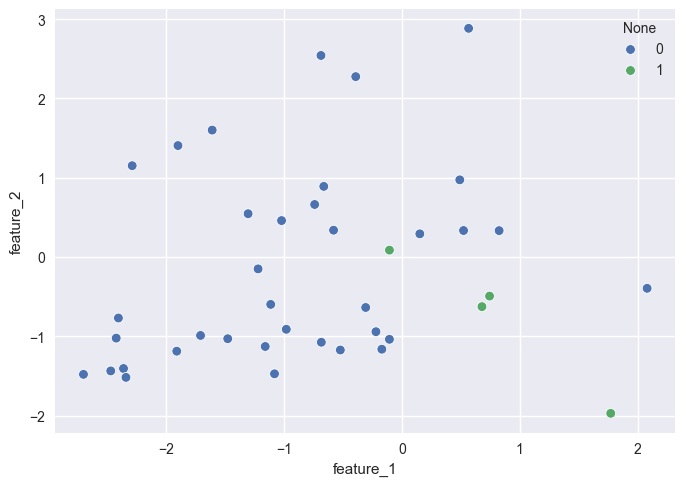

In [72]:
# Задание 3.3
# Ниже представлен код для генерации задачи классификации и отрисовки диаграммы рассеяния с цветовой группировкой по классам:
'''
from sklearn import datasets
X, y = datasets.make_classification(
    n_samples=200, #количество объектов
    n_features=2, #количество признаков
    n_informative=2, #количество информативных признаков
    n_redundant=0, #количество неинформативных признаков
    n_classes=2, #количество классов
    weights=[1, 0.2], #пропорции классов
    random_state=40 #генератор случайных чисел
)
X = pd.DataFrame(X, columns=['feature_1', 'feature_2'])
y = pd.Series(y)
sns.scatterplot(x=X['feature_1'], y=X['feature_2'], hue=y);
'''
# Разбейте исходный набор данных на тренировочный и валидационный со стратификацией по классам в соотношении 80/20. 
# В качестве значения параметра random_state возьмите число 42.
# Постройте диаграммы рассеяния с цветовой группировкой по классам для валидационной выборки.
# Из приведённых ниже диаграмм выберите ту, которая соответствует полученному разбиению:

from sklearn import datasets

X, y = datasets.make_classification(
    n_samples=200, #количество объектов
    n_features=2, #количество признаков
    n_informative=2, #количество информативных признаков
    n_redundant=0, #количество неинформативных признаков
    n_classes=2, #количество классов
    weights=[1, 0.2], #пропорции классов
    random_state=40 #генератор случайных чисел
)

X = pd.DataFrame(X, columns=['feature_1', 'feature_2'])
y = pd.Series(y)

X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

sns.scatterplot(x=X_valid['feature_1'], y=X_valid['feature_2'], hue=y);

##### ВЫБОР МЕТРИК В УСЛОВИЯХ ДИСБАЛАНСА КЛАССОВ

In [73]:
X, y = water_data.drop('Potability', axis=1), water_data['Potability']

In [74]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42, #генератор случайных чисел
)
#Обучаем модель на тренировочной выборке
model.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик
print(metrics.classification_report(y_valid, y_valid_pred)) 

              precision    recall  f1-score   support

           0       0.76      0.92      0.83       400
           1       0.81      0.55      0.65       256

    accuracy                           0.77       656
   macro avg       0.78      0.73      0.74       656
weighted avg       0.78      0.77      0.76       656



In [75]:
# Задание 3.5
# Для выполнения этого задания используйте сгенерированные тренировочную и валидационную выборки из задания 3.3.
# Обучите модель логистической регрессии на тренировочной выборке (все параметры оставьте по умолчанию).
# Сделайте предсказание для валидационной выборки и рассчитайте метрики классификации. Ответ округлите до двух знаков после точки-разделителя.
from sklearn import datasets

X, y = datasets.make_classification(
    n_samples=200, #количество объектов
    n_features=2, #количество признаков
    n_informative=2, #количество информативных признаков
    n_redundant=0, #количество неинформативных признаков
    n_classes=2, #количество классов
    weights=[1, 0.2], #пропорции классов
    random_state=40 #генератор случайных чисел
)

X = pd.DataFrame(X, columns=['feature_1', 'feature_2'])
y = pd.Series(y)

X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

log_reg = linear_model.LogisticRegression()

log_reg.fit(X_train, y_train)

y_train_pred = log_reg.predict(X_train)
y_valid_pred = log_reg.predict(X_valid)

print(metrics.classification_report(y_valid, y_valid_pred)) 

              precision    recall  f1-score   support

           0       0.92      0.97      0.95        36
           1       0.50      0.25      0.33         4

    accuracy                           0.90        40
   macro avg       0.71      0.61      0.64        40
weighted avg       0.88      0.90      0.88        40



c:\Users\Blooodniy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


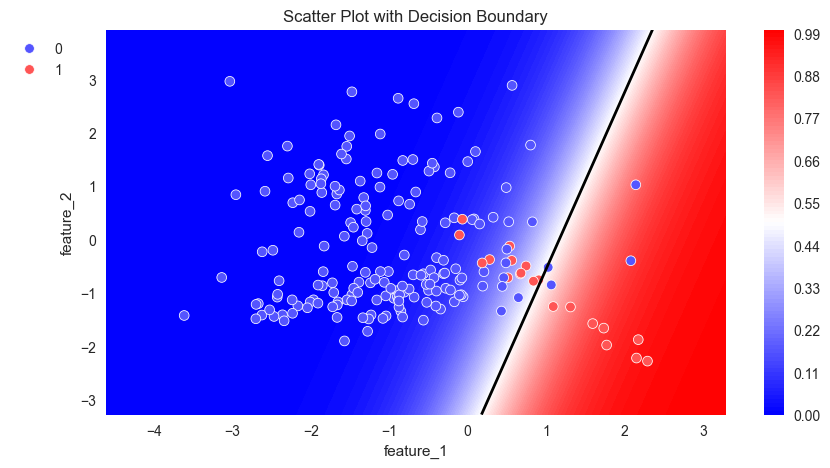

In [76]:
# Задание 3.6 (на самопроверку)
#Воспользуйтесь функцией plot_probabilities_2d(), которую мы написали в модуле по классификации, для того чтобы построить разделяющую поверхность логистической регрессии.
# Передайте в её аргументы матрицу наблюдений X, вектор ответов y и обученную в задании 3.5 логистическую регрессию.

def plot_probabilities_2d(X, y, model):
    xx1, xx2 = np.meshgrid(
        np.arange(X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1, 0.1),
        np.arange(X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1, 0.1)
    )
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    probs = model.predict_proba(X_net)[:, 1]
    probs = probs.reshape(xx1.shape)
    fig, ax = plt.subplots(figsize = (10, 5))
    contour = ax.contourf(xx1, xx2, probs, 100, cmap='bwr')
    bound = ax.contour(xx1, xx2, probs, [0.5], linewidths=2, colors='black');
    colorbar = fig.colorbar(contour)
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=y, palette='seismic', ax=ax)
    ax.set_title('Scatter Plot with Decision Boundary');
    ax.legend(bbox_to_anchor=(-0.05, 1))
    
plot_probabilities_2d(X, y, log_reg)

##### ПОСТРОЕНИЕ МОДЕЛИ В УСЛОВИЯХ ДИСБАЛАНСА КЛАССОВ

ВЗВЕШИВАНИЕ ОБЪЕКТОВ

In [77]:
X, y = water_data.drop('Potability', axis=1), water_data['Potability']
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [78]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42, #генератор случайных чисел
    class_weight='balanced' #веса классов
)
#Обучаем модель на тренировочной выборке
model.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик    
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.82      0.71      0.76       400
           1       0.63      0.76      0.69       256

    accuracy                           0.73       656
   macro avg       0.72      0.73      0.72       656
weighted avg       0.74      0.73      0.73       656



In [79]:
# Задание 3.7
# Для выполнения этого задания используйте сгенерированные тренировочную и валидационную выборки из задания 3.3.
# Обучите модель логистической регрессии на тренировочной выборке, установив сбалансированные веса для классов.
# Сделайте предсказание для валидационной выборки и рассчитайте метрики классификации. Ответ округлите до двух знаков после точки-разделителя.
X, y = datasets.make_classification(
    n_samples=200, #количество объектов
    n_features=2, #количество признаков
    n_informative=2, #количество информативных признаков
    n_redundant=0, #количество неинформативных признаков
    n_classes=2, #количество классов
    weights=[1, 0.2], #пропорции классов
    random_state=40 #генератор случайных чисел
)

X = pd.DataFrame(X, columns=['feature_1', 'feature_2'])
y = pd.Series(y)

X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

log_reg = linear_model.LogisticRegression(class_weight='balanced')

log_reg.fit(X_train, y_train)

y_train_pred = log_reg.predict(X_train)
y_valid_pred = log_reg.predict(X_valid)

print(metrics.classification_report(y_valid, y_valid_pred)) 

              precision    recall  f1-score   support

           0       0.97      0.83      0.90        36
           1       0.33      0.75      0.46         4

    accuracy                           0.82        40
   macro avg       0.65      0.79      0.68        40
weighted avg       0.90      0.82      0.85        40



c:\Users\Blooodniy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


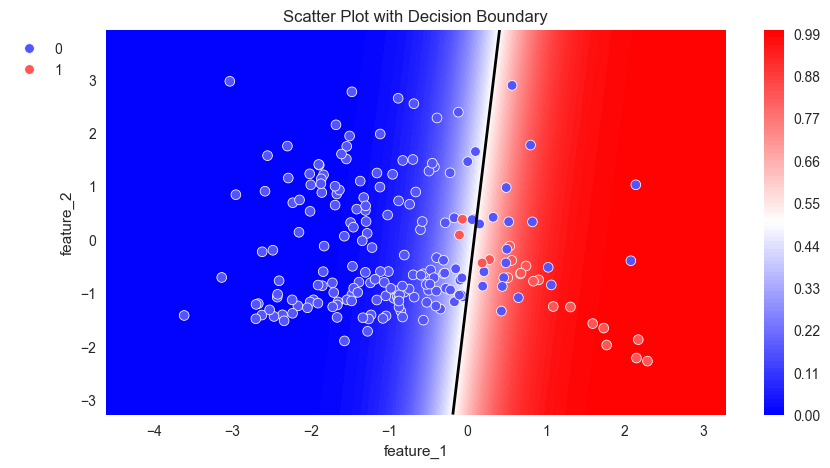

In [80]:
# Задание 3.8 (на самопроверку)
# Воспользуйтесь функцией plot_probabilities_2d(), которую мы написали в модуле по классификации, 
# для того чтобы построить разделяющую поверхность логистической регрессии со сбалансированными весами классов.
# Примечание. Код функции plot_probabilities_2d() вы можете найти в задании 3.6.
# Передайте в её аргументы матрицу наблюдений X, вектор ответов y и обученную в задании 3.7 логистическую регрессию.
# Сравните разделяющую поверхность, построенную в задании 3.5, с полученной вами поверхностью в данном задании.

plot_probabilities_2d(X, y, log_reg)

ВЫБОР ПОРОГА ВЕРОЯТНОСТИ. PR-КРИВАЯ

In [81]:
X, y = water_data.drop('Potability', axis=1), water_data['Potability']
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [82]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел 
)
#Обучаем модель
model.fit(X_train, y_train)
#Создаём кросс-валидатор k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
#Делаем предсказание вероятностей на кросс-валидации
y_cv_proba_pred = model_selection.cross_val_predict(model, X_train, y_train, cv=skf, method='predict_proba')
y_cv_proba_pred

array([[0.        , 1.        ],
       [0.24561404, 0.75438596],
       [1.        , 0.        ],
       ...,
       [0.60621762, 0.39378238],
       [1.        , 0.        ],
       [0.03030303, 0.96969697]])

In [83]:
#Выделяем столбец с вероятностями для класса 1 
y_cv_proba_pred = y_cv_proba_pred[:, 1]

In [84]:
#Вычисляем координаты PR-кривой
precision, recall, thresholds = metrics.precision_recall_curve(y_train, y_cv_proba_pred)

print('Thresholds:', thresholds[:5])
print('Precision scores:', precision[:5])
print('Recall scores:',recall[:5])

Thresholds: [0.         0.02739726 0.02898551 0.05       0.07407407]
Precision scores: [0.39007634 0.50050659 0.50357873 0.50437919 0.5043837 ]
Recall scores: [1.         0.9667319  0.96379648 0.95792564 0.95694716]


Best threshold = 0.33, F1-Score = 0.69


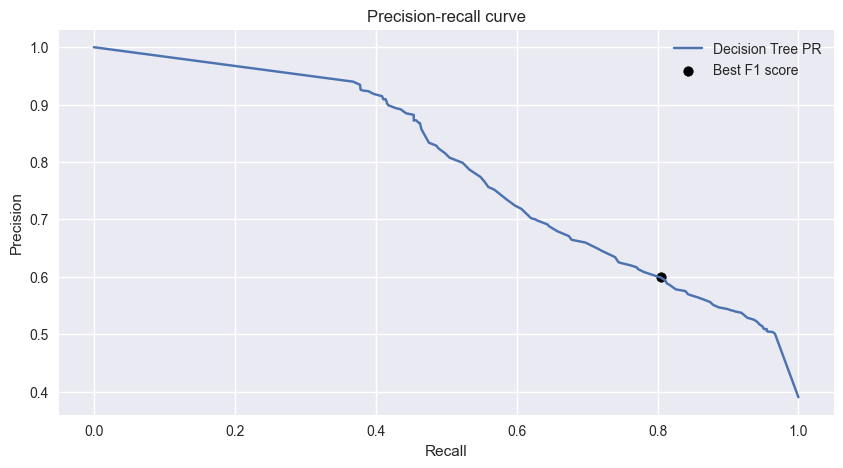

In [85]:
#Вычисляем F1-меру при различных threshold
f1_scores = (2 * precision * recall) / (precision + recall)
#Определяем индекс максимума
idx = np.argmax(f1_scores)
print('Best threshold = {:.2f}, F1-Score = {:.2f}'.format(thresholds[idx], f1_scores[idx]))

#Строим PR-кривую
fig, ax = plt.subplots(figsize=(10, 5)) #фигура + координатная плоскость
#Строим линейный график зависимости precision от recall
ax.plot(recall, precision, label='Decision Tree PR')
#Отмечаем точку максимума F1
ax.scatter(recall[idx], precision[idx], marker='o', color='black', label='Best F1 score')
#Даем графику название и подписи осям
ax.set_title('Precision-recall curve')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
#Отображаем легенду
ax.legend();

In [86]:
#Задаём оптимальный порог вероятностей
threshold_opt = 0.33
#Образцы воды, для которых вероятность быть пригодными для питья > threshold_opt, относим к классу 1
#В противном случае — к классу 0
y_valid_pred_proba = model.predict_proba(X_valid)[:, 1]
y_valid_pred = (y_valid_pred_proba > threshold_opt).astype('int')
#Считаем метрики
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.82      0.70      0.76       400
           1       0.62      0.76      0.68       256

    accuracy                           0.73       656
   macro avg       0.72      0.73      0.72       656
weighted avg       0.74      0.73      0.73       656



In [87]:
print('PR AUC: {:.2f}'.format(metrics.auc(recall, precision)))
# PR AUC: 0.79

PR AUC: 0.79


СЭМПЛИРОВАНИЕ


Для пользователей pip:
```sh
!pip install imbalanced-learn
```
Для пользователей anaconda:
```sh
!conda install -c conda-forge imbalanced-learn
```

In [88]:
from imblearn.over_sampling import SMOTE

In [89]:
sm = SMOTE(random_state=2)
X_train_s, y_train_s = sm.fit_resample(X_train, y_train)

print('Train shape before oversampling:', X_train.shape) 
print('Class balance before oversampling: \n', y_train.value_counts(), sep='')
print('-'*40)
print('Train shape after oversampling:', X_train_s.shape)
print('Class balance after oversampling: \n', y_train_s.value_counts(), sep='')

Train shape before oversampling: (2620, 9)
Class balance before oversampling: 
Potability
0    1598
1    1022
Name: count, dtype: int64
----------------------------------------
Train shape after oversampling: (3196, 9)
Class balance after oversampling: 
Potability
0    1598
1    1598
Name: count, dtype: int64


In [90]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42, #генератор случайных чисел
)
#Обучаем модель на тренировочной выборке (с сэмплированием)
model.fit(X_train_s, y_train_s)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик    
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.83      0.70      0.76       400
           1       0.63      0.78      0.69       256

    accuracy                           0.73       656
   macro avg       0.73      0.74      0.73       656
weighted avg       0.75      0.73      0.73       656



In [91]:
# Задание 3.11
# Для выполнения этого задания используйте сгенерированные тренировочную и валидационную выборки из задания 3.3.
# Сбалансируйте тренировочную выборку с помощью алгоритма SMOTE. В качестве значения параметра random_state возьмите число 42, остальные параметры оставьте по умолчанию.
# Обучите модель логистической регрессии на пересэмплированной тренировочной выборке. Все параметры оставьте по умолчанию.
# Сделайте предсказание для валидационной выборки и рассчитайте метрики классификации. Ответ округлите до двух знаков после точки-разделителя.
X, y = datasets.make_classification(
    n_samples=200, #количество объектов
    n_features=2, #количество признаков
    n_informative=2, #количество информативных признаков
    n_redundant=0, #количество неинформативных признаков
    n_classes=2, #количество классов
    weights=[1, 0.2], #пропорции классов
    random_state=40 #генератор случайных чисел
)

X = pd.DataFrame(X, columns=['feature_1', 'feature_2'])
y = pd.Series(y)

X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

sm = SMOTE(random_state=42)
X_train_s, y_train_s = sm.fit_resample(X_train, y_train)

log_reg = linear_model.LogisticRegression()

log_reg.fit(X_train_s, y_train_s)

y_valid_pred = log_reg.predict(X_valid)

print(metrics.classification_report(y_valid, y_valid_pred)) 

              precision    recall  f1-score   support

           0       0.97      0.89      0.93        36
           1       0.43      0.75      0.55         4

    accuracy                           0.88        40
   macro avg       0.70      0.82      0.74        40
weighted avg       0.92      0.88      0.89        40



c:\Users\Blooodniy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


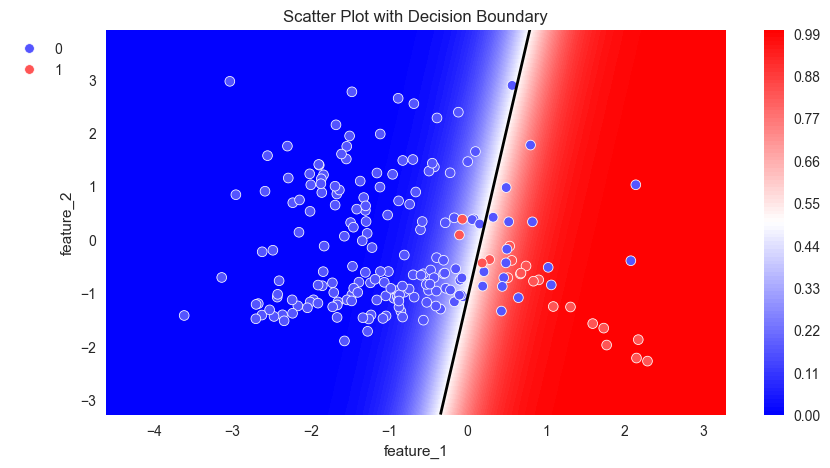

In [92]:
# Задание 3.12 (на самопроверку)
# Воспользуйтесь функцией plot_probabilities_2d(), которую мы написали в модуле по классификации, 
# для того чтобы построить разделяющую поверхность логистической регрессии со сбалансированными весами классов.
# Примечание. Код функции plot_probabilities_2d() вы можете найти в задании 3.6.
# Передайте в её аргументы матрицу наблюдений X, вектор ответов y и обученную в задании 3.11 логистическую регрессию.
# Сравните разделяющую поверхность, построенную в заданиях 3.5 и 3.7, с полученной вами поверхностью в данном задании.
plot_probabilities_2d(X, y, log_reg)

---
### 4. Недообучение и переобучение. Утечка данных

##### КАК ОБНАРУЖИТЬ ПЕРЕОБУЧЕНИЕ

In [93]:
X, y = water_data.drop('Potability', axis=1), water_data['Potability']

In [94]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
#Создаём модель
model_bad = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    class_weight='balanced', #веса классов
    random_state=42 #генератор случайных чисел
)
#Обучаем модель на тренировочной выборке
model_bad.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model_bad.predict(X_train)
y_valid_pred = model_bad.predict(X_valid)
#Выводим значения метрик для тренировочной выборки
print('Train F1 score: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
#Выводим значения метрик для валидационной выборки
print('Valid F1 score: {:.2f}'.format(metrics.f1_score(y_valid, y_valid_pred)))
 
# Train F1 score: 1.00
# Valid F1 score: 0.67

Train F1 score: 1.00
Valid F1 score: 0.67


In [95]:
#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
 
#Считаем метрики на кросс-валидации k-fold со стратификацией
cv_metrics = model_selection.cross_validate(
    estimator=model_bad, #модель
    X=X, #матрица наблюдений X
    y=y, #вектор ответов y
    cv=skf, #кросс-валидатор
    scoring='f1', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
display(cv_metrics)

{'fit_time': array([0.09596944, 0.08996916, 0.09598875, 0.08897614, 0.09196496]),
 'score_time': array([0.00399995, 0.00399899, 0.00299692, 0.00299478, 0.00299954]),
 'test_score': array([0.61445783, 0.68421053, 0.62332696, 0.63276836, 0.70119522]),
 'train_score': array([1., 1., 1., 1., 1.])}

In [96]:
print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['test_score'])))
## Train k-fold mean f1: 1.00
## Valid k-fold mean f1: 0.65

Train k-fold mean f1: 1.00
Valid k-fold mean f1: 0.65


Train accuracy score: 0.98
Valid accuracy score: 0.81


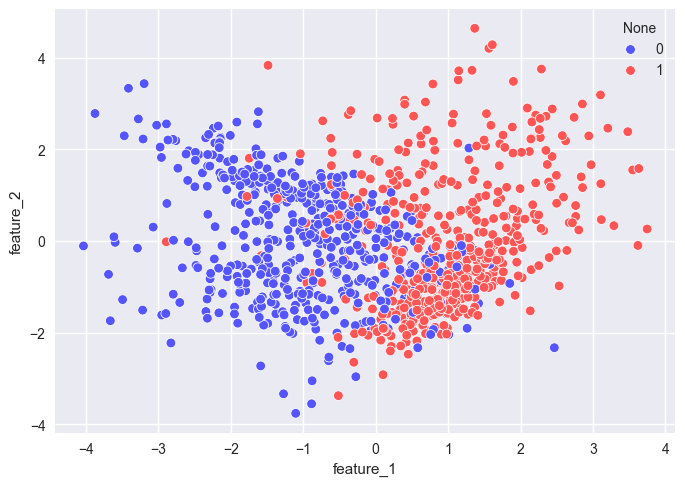

In [97]:
# Задание 4.3
# Ниже представлен код для генерации задачи классификации и отрисовки диаграммы рассеяния с цветовой группировкой по классам.

from sklearn import datasets
X, y = datasets.make_classification(
    n_samples=1000, #количество объектов
    n_features=2, #количество признаков
    n_informative=2, #количество информативных признаков
    n_redundant=0, #количество неинформативных признаков
    n_classes=2, #количество классов
    n_clusters_per_class=2, #количество кластеров внутри класса
    random_state=1 #генератор случайных чисел
)
X = pd.DataFrame(X, columns=['feature_1', 'feature_2'])
y = pd.Series(y)
sns.scatterplot(x=X['feature_1'], y=X['feature_2'], hue=y, palette='seismic');

# Разделите исходный набор данных на тренировочную и валидационную выборки в соотношении 70/30, используя функцию train_test_split(). 
# В качестве значения параметра random_state возьмите число 42.
# Обучите модель дерева решений с глубиной 10 (остальные параметры оставьте по умолчанию) для решения задачи классификации на тренировочной выборке. 
# Сделайте предсказания для тренировочной и валидационной выборок и рассчитайте метрику accuracy.
# В качестве ответа укажите значение метрики accuracy на тренировочной и валидационной выборках. Ответ округлите до двух знаков после точки-разделителя.

X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

model_ex = tree.DecisionTreeClassifier(max_depth=10)

model_ex.fit(X_train, y_train)

y_train_pred = model_ex.predict(X_train)
y_valid_pred = model_ex.predict(X_valid)

print('Train accuracy score: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Valid accuracy score: {:.2f}'.format(metrics.accuracy_score(y_valid, y_valid_pred)))

c:\Users\Blooodniy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


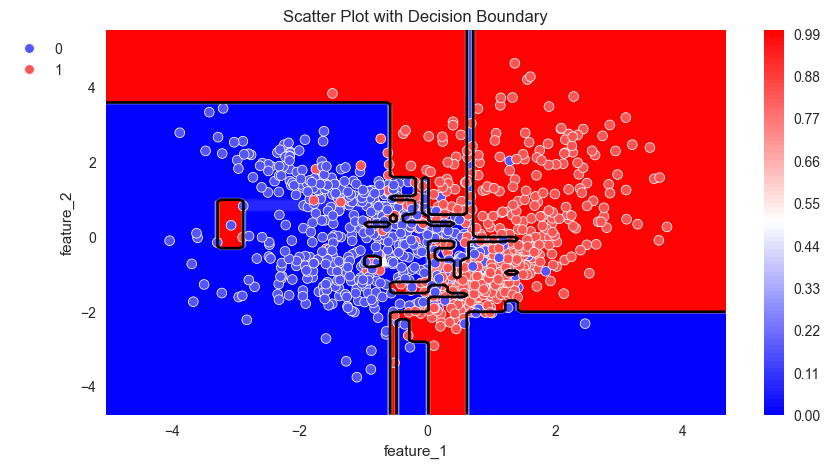

In [98]:
# Задание 4.4 (на самопроверку)
# Воспользуйтесь функцией plot_probabilities_2d() и постройте разделяющую поверхность обученного дерева решений.
# Примечание. Код функции plot_probabilities_2d() вы можете найти в задании 3.6.
# Передайте в её аргументы матрицу наблюдений X, вектор ответов y и обученное в задании 4.3 дерево решений.
# Является ли ваша модель переобученной?
plot_probabilities_2d(X, y, model_ex)

##### МЕТОДЫ БОРЬБЫ С ПЕРЕОБУЧЕНИЕМ

In [101]:
X, y = water_data.drop('Potability', axis=1), water_data['Potability']

In [102]:
print('Current depth:', model_bad.get_depth())
## Current depth: 27

Current depth: 27


In [107]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #ограничиваем глубину дерева
    random_state=42, #генератор случайных чисел
    class_weight='balanced' #веса классов
)
 
#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
 
#Считаем метрики на кросс-валидации k-fold со стратификацией
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X, #матрица наблюдений X
    y=y, #вектор ответов y
    cv=skf, #кросс-валидатор
    scoring='f1', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
 
print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['test_score'])))


## Train k-fold mean f1: 0.75
## Valid k-fold mean f1: 0.66

Train k-fold mean f1: 0.75
Valid k-fold mean f1: 0.66


In [108]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #ограничиваем глубину дерева
    min_samples_leaf=5, #увеличиваем количество объектов в листе
    random_state=42, #генератор случайных чисел
    class_weight='balanced' #веса классов
)
 
#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
 
#Считаем метрики на кросс-валидации k-fold со стратификацией
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X, #матрица наблюдений X
    y=y, #вектор ответов y
    cv=skf, #кросс-валидатор
    scoring='f1', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
 
print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['test_score'])))
## Train k-fold mean f1: 0.74
## Valid k-fold mean f1: 0.66

Train k-fold mean f1: 0.74
Valid k-fold mean f1: 0.66


In [113]:
# Задание 4.6
# Для выполнения этого задания используйте сгенерированные тренировочную и валидационную выборки из задания 4.3.
# Обучите модель дерева решений с глубиной 3 (остальные параметры оставьте по умолчанию) для решения задачи классификации на тренировочной выборке.
# Сделайте предсказания для тренировочной и валидационной выборок и рассчитайте метрику accuracy.
# В качестве ответа укажите значение метрики accuracy на тренировочной и валидационной выборках. Ответ округлите до двух знаков после точки-разделителя.

X, y = datasets.make_classification(
    n_samples=1000, #количество объектов
    n_features=2, #количество признаков
    n_informative=2, #количество информативных признаков
    n_redundant=0, #количество неинформативных признаков
    n_classes=2, #количество классов
    n_clusters_per_class=2, #количество кластеров внутри класса
    random_state=1 #генератор случайных чисел
)

X = pd.DataFrame(X, columns=['feature_1', 'feature_2'])
y = pd.Series(y)

X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

model_ex_2 = tree.DecisionTreeClassifier(max_depth=3)
model_ex_2.fit(X_train, y_train)

y_train_pred = model_ex_2.predict(X_train)
y_valid_pred = model_ex_2.predict(X_valid)

print('Train accuracy score: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Valid accuracy score: {:.2f}'.format(metrics.accuracy_score(y_valid, y_valid_pred)))


Train accuracy score: 0.88
Valid accuracy score: 0.85


c:\Users\Blooodniy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


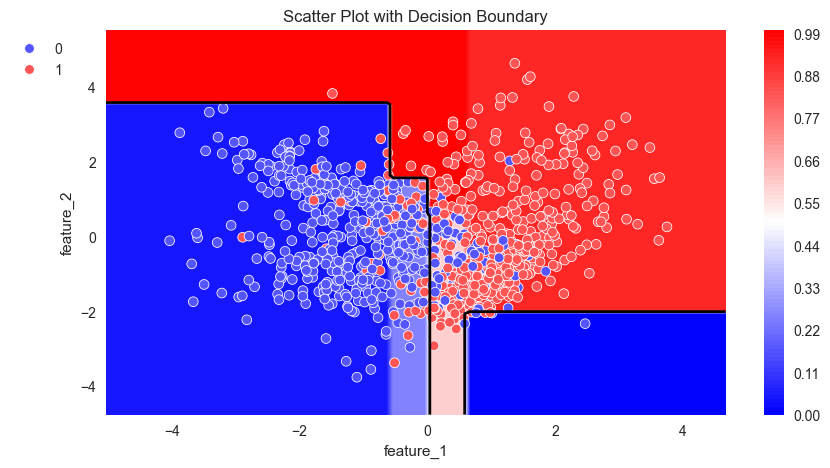

In [114]:
# Задание 4.7 (на самопроверку)
# Воспользуйтесь функцией plot_probabilities_2d() и постройте разделяющую поверхность обученного дерева решений.
# Примечание. Код функции plot_probabilities_2d() вы можете найти в задании 3.6.
# Передайте в её аргументы матрицу наблюдений X, вектор ответов y и обученное в задании 4.6 дерево решений.
# Удалось ли вам избавиться от переобучения модели?
plot_probabilities_2d(X, y, model_ex_2)

---
### 5. Кривая обучения